# Udacity Self-Driving Car Engineer Nanodegree

## Project: Use Deep Learning to Clone Driving Behavior

### This project will use CNN's to clone driving behavior for an autonomous vehicle.

## Project Goals / Deliverables
- Use the simulator to collect data of good driving behavior
- Design, Train and Validate a model that predicts a steering angle from image data
- Use the model to drive the vehicle autonomously for an entire loop around the simulator track

## Project Files
- **model.ipynb** script used to create and train the model
- **model.h5:** trained Keras model (for loading into drive.py)
- **drive.py:** script to drive the car
- **README.ipynb:** report writeup file

## References
ref: [NVIDIA: End to End Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)  
ref: [Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)](https://arxiv.org/abs/1511.07289)  

ref: [Udacity's Self-Driving Car Nanodegree](https://www.udacity.com/drive)  
ref: [Udacity's Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim)  
ref: [Behaviorial Cloning Project](Behaviorial Cloning Project)  

## Data Source
ref: [Sample Simulator Data](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)  

active py35  
pip install eventlet  
pip install flask-socketio  

## Deep Learning: Model Architecture (NVIDIA)

**This project is based on the NVIDIA paper: [End to End Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)**  

"(NVIDIA) trained a convolutional neural network (CNN) to map raw pixels from a single front-facing camera directly to steering commands. This end-to-end approach proved surprisingly powerful. With minimum training data from humans the system learns to drive in traffic on local roads with or without lane markings and on highways.  It also operates in areas with unclear visual guidance such as in parking lots and on unpaved roads.The system automatically learns internal representations of the necessary processing steps such as detecting useful road features with only the human steering angle as the training signal. We never explicitly trained it to detect, for example, the outline of roads."  

The Model Architecture for NVIDIA is shown below.  

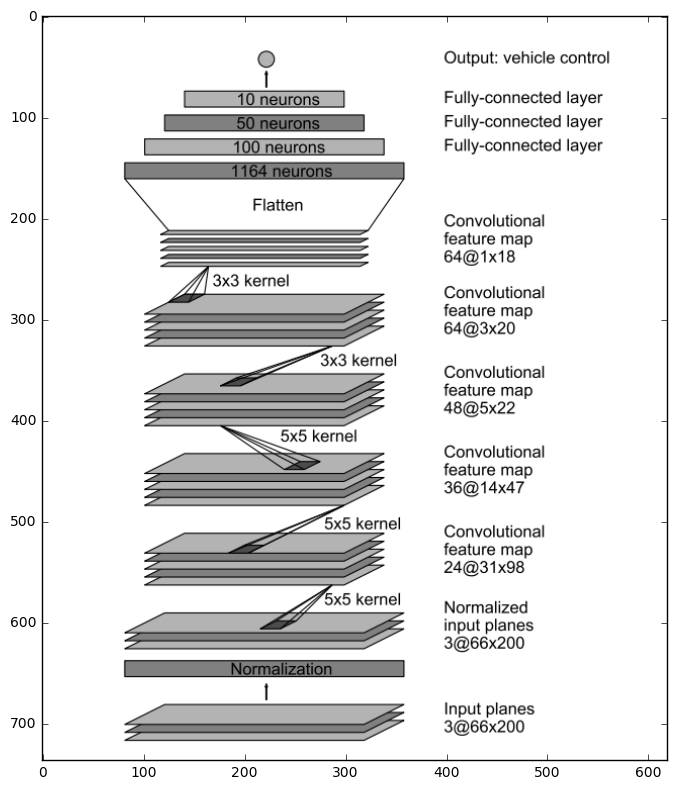

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('cnn architecture.png')
plt.figure(figsize=(20, 8))
plt.imshow(img)
plt.tight_layout()
plt.show()

## Load Libraries

In [3]:
import cv2
import time ### use this ###
import glob
import numpy as np
import pandas as pd
from random import getrandbits
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, MaxPooling2D, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, Nadam
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

%matplotlib inline

import sys
print(sys.version)
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)
import keras
print('Keras Version:',keras.__version__)

Using TensorFlow backend.


3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
device: 0, name: GeForce GT 730M, pci bus id: 0000:01:00.0 /gpu:0
Keras Version: 2.0.2


## Dataset Summary

Udacity's Self-Driving Car Simulator provides the option to collect sample data by driving the car along 2 different tracks in either direction. Sample Data has also been provided for 8 laps around Track 1 driving in clockwise and counter clockwise directions. Training Data collects images from Center, Left and Right mounted cameras along with values for Steering, Throttle, Brake and Speed.


In the interests of saving time, this project will be using the Sample Data.
There are 8036 snapshots in time for this dataset.

In [4]:
df = pd.read_csv("data\driving_log.csv")
df.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


## Exploratory Visualization: Steering Input, Throttle Input

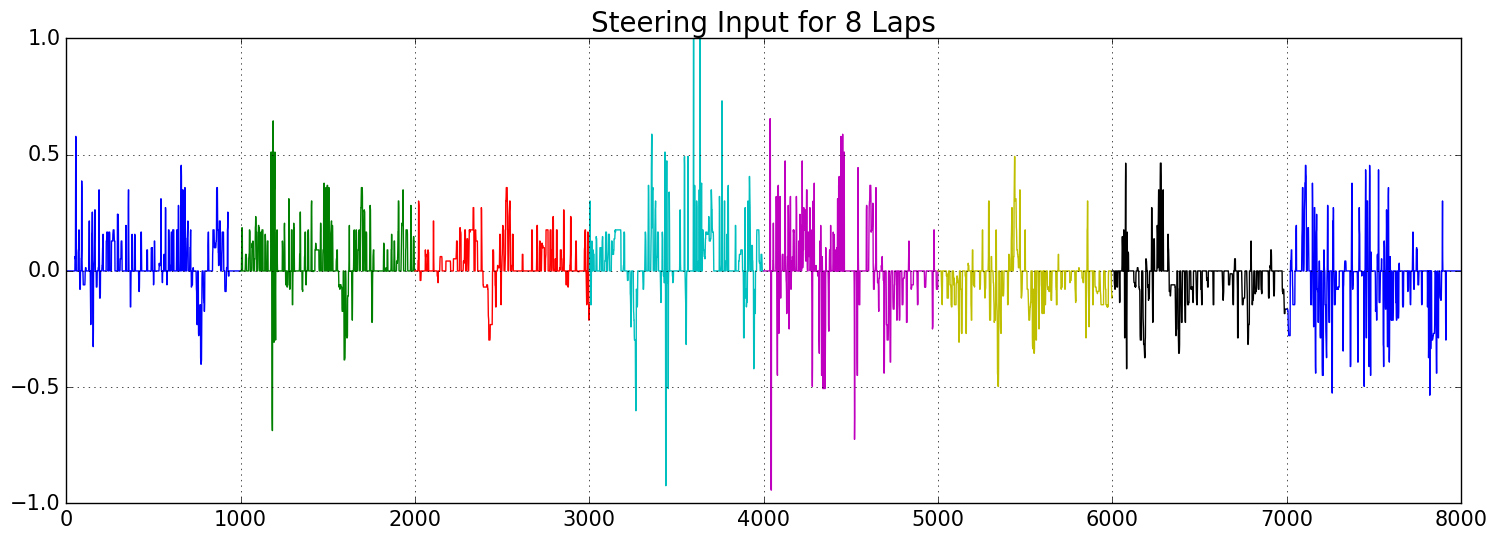

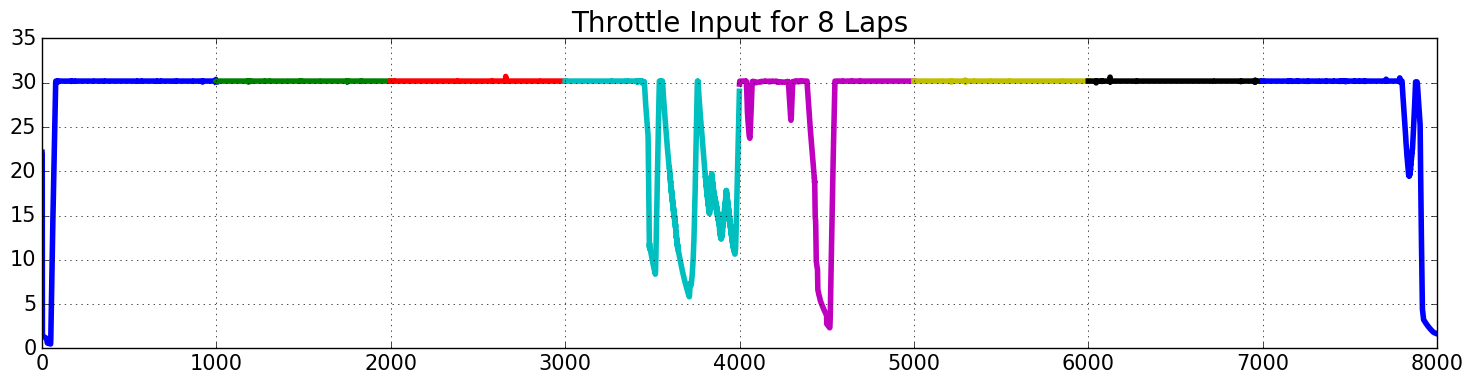

In [5]:
steering = df['steering']
speed = df['speed']

fig = plt.figure(figsize=(18,6))
plt.title('Steering Input for 8 Laps',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(steering[0:1000])
plt.plot(steering[1000:2000])
plt.plot(steering[2000:3000])
plt.plot(steering[3000:4000])
plt.plot(steering[4000:5000])
plt.plot(steering[5000:6000])
plt.plot(steering[6000:7000])
plt.plot(steering[7000:8000])
plt.grid()
plt.show()

fig = plt.figure(figsize=(18,4))
plt.title('Throttle Input for 8 Laps',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(speed[0:1000], lw=4)
plt.plot(speed[1000:2000], lw=4)
plt.plot(speed[2000:3000], lw=4)
plt.plot(speed[3000:4000], lw=4)
plt.plot(speed[4000:5000], lw=4)
plt.plot(speed[5000:6000], lw=4)
plt.plot(speed[6000:7000], lw=4)
plt.plot(speed[7000:8000], lw=4)
plt.grid()
plt.show()

## Exploratory Visualization: Unique Steering Counts

Plotting the unique steering counts shows that the dataset is dominated (54% of samples) by samples with zero for steering input. The average value for steering input is also positive which shows that there is a right hand turning bias present in the dataset. 

Number of Steering Values: 8036
Unique Steering Values: 124
Ave 0.0041
Std 0.1288 



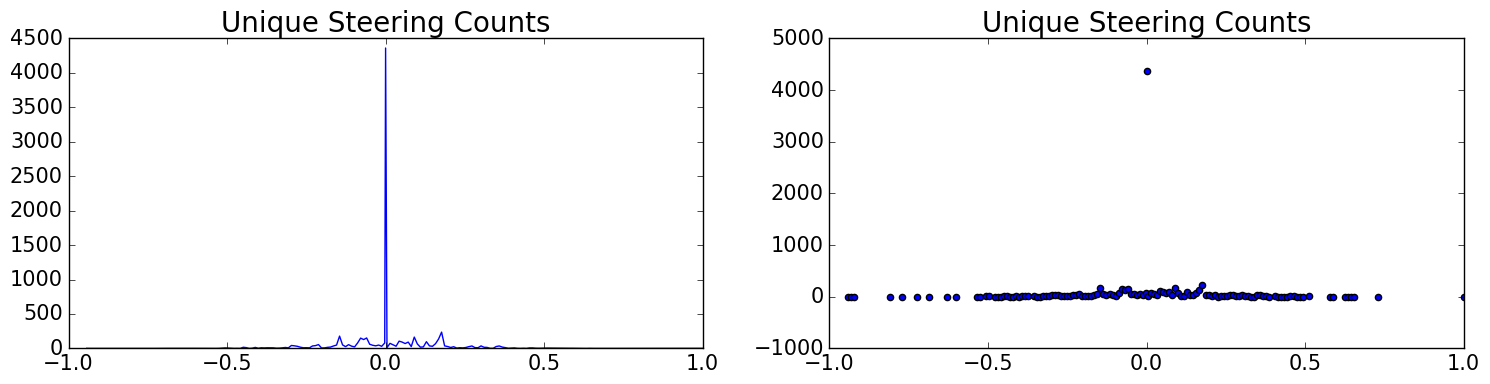

Removing Steering Values Equal to Zero...

Number of Steering Values: 3675
Unique Steering Values: 123
Ave 0.0089
Std 0.1904 



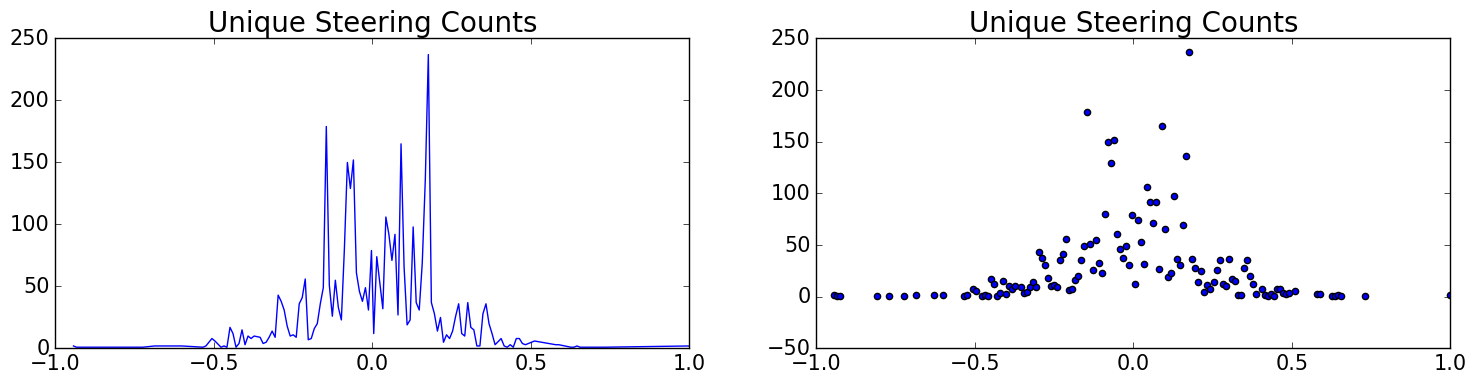

In [6]:
def show_plots(df):
    unique = np.unique(df['steering'], return_counts=True)
    
    print ('Number of Steering Values:',len(df))
    print ('Unique Steering Values:',len(unique[0]))
    print ('Ave',round(np.mean(df['steering']),4))
    print ('Std',round(np.std(df['steering']),4),'\n')

    fig = plt.figure(figsize=(18,4))
    a = fig.add_subplot(1,2,1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(-1.0,1.0)
    plt.title('Unique Steering Counts',fontsize=20)
    plt.plot(unique[0],unique[1])
    a = fig.add_subplot(1,2,2)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(-1.0,1.0)
    plt.title('Unique Steering Counts',fontsize=20)
    plt.scatter(unique[0],unique[1])
    plt.show()
    return None

unique = np.unique(df['steering'], return_counts=True)
show_plots(df)

print ('Removing Steering Values Equal to Zero...\n')
df_2 = df[df['steering'] != 0]
show_plots(df_2)

## Exploratory Visualization: Preprocessing Data

Sample Images for Track 1 and 2 are shown below. The shapes for this dataset are (160,320). When driving your eyes are naturally focused at the horizon of the road surface. The top 55 y_pixels of our images do not contain any steering information. Cropping has been applied to all images to remove these pixels. The next row of images shows that all samples have been resized (96,96). This reduces the data inputs by 73% while still retaining valuable visual feature for steering input. The final row of images show that the dataset has been augmented by flipping every image (and corresponding steering input). This doubles the size of the training set, but also removes the right hand steering input bias from the dataset.

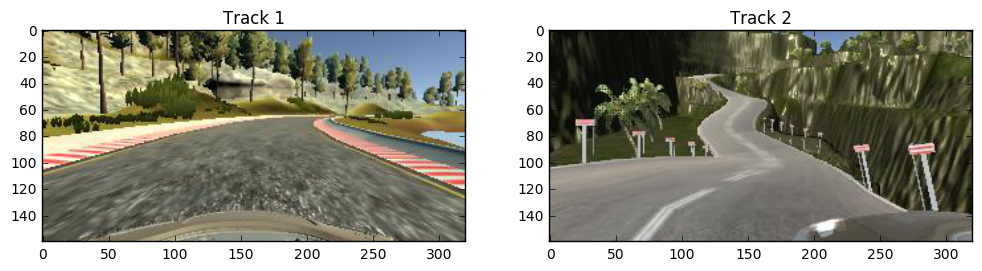

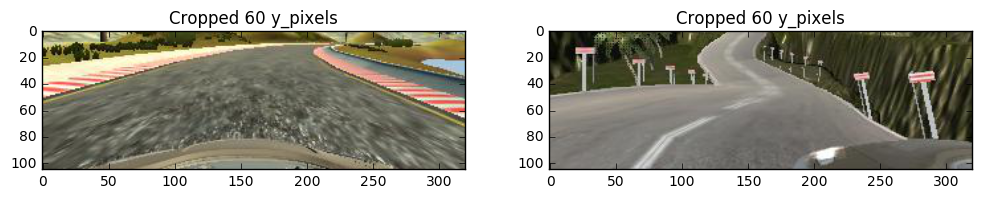

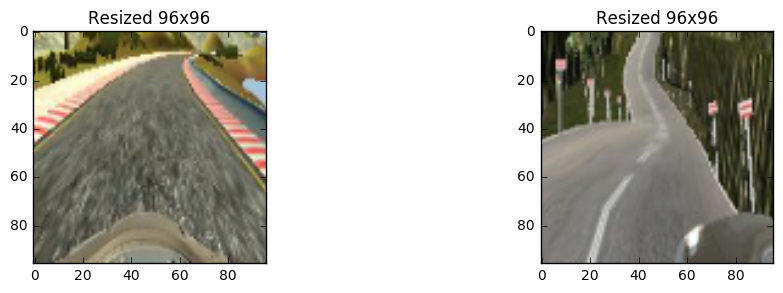

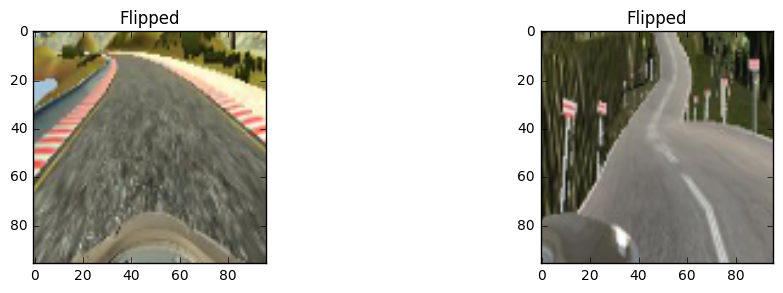

In [7]:
sample_pics = glob.glob('*.jpg')
img_1 = mpimg.imread(sample_pics[0])
img_2 = mpimg.imread(sample_pics[1])

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Track 1')
plt.imshow(img_1)
plt.subplot(122)
plt.title('Track 2')
plt.imshow(img_2)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Cropped 60 y_pixels')
plt.imshow(img_1[55:, :])
plt.subplot(122)
plt.title('Cropped 60 y_pixels')
plt.imshow(img_2[55:, :])
plt.show()

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title('Resized 96x96')
plt.imshow(cv2.resize(img_1[55:, :], (96, 96), cv2.INTER_AREA))
plt.subplot(122)
plt.title('Resized 96x96')
plt.imshow(cv2.resize(img_2[55:, :], (96, 96), cv2.INTER_AREA))
plt.show()

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title('Flipped')
plt.imshow(np.fliplr(cv2.resize(img_1[55:, :], (96, 96), cv2.INTER_AREA)))
plt.subplot(122)
plt.title('Flipped')
plt.imshow(np.fliplr(cv2.resize(img_2[55:, :], (96, 96), cv2.INTER_AREA)))
plt.show()

## Preprocess Data

The training data should have samples with zero steering input so that our autonomous car knows when to drive straight. At the same time, we don't want the dataset dominated by these samples. Experimental results show that randomly retaining 5% of zero steering input images provide good balance for the overall model. Since the left and right camera images only have steering inputs for the center camera image, offsets need to be determined experimentally. Plus/Minus 0.25 for Left/Right was found to work well for the model. 10% of the Center Images were retained for a Testing Set.

In [8]:
def get_train_valid_data():
    slice = 1 # 1
    df = pd.read_csv('./data/driving_log.csv')
    df = df.iloc[::slice,:] 

    df1 = df[df['steering'] != 0]
    df2 = df[df['steering'] == 0].sample(frac=0.05) # 0.05
    df3 = pd.concat((df1,df2))
    df3 = shuffle(df3)  
    
    df3.drop(['throttle','brake','speed'],inplace=True,axis=1)
    df3 = df3.rename(columns = {'steering':'steer_center'})
    df3['steer_left'] = df3['steer_center'] + 0.25
    df3['steer_right'] = df3['steer_center'] - 0.25
    #df3.head()

    center = df3['center']
    left = df3['left']
    right = df3['right'] 

    steer_center = df3['steer_center']
    steer_left = df3['steer_left'] 
    steer_right = df3['steer_right'] 

    # use only center images for validation
    X_train, X_valid, y_train, y_valid = \
        train_test_split(center, steer_center, test_size=0.1, random_state=0)

    X_train = X_train.append(left)
    X_train = X_train.append(right)

    y_train = y_train.append(steer_left)
    y_train = y_train.append(steer_right)

    print ('Training and Validation, Before Preprocessing...\n')
    print ('X_train Samples, Steering mean, Steering stdev:',
           len(X_train),np.round(np.mean(y_train),4),np.round(np.std(y_train),4))
    print ('X_valid Samples, Steering mean, Steering stdev:',
           len(X_valid),np.round(np.mean(y_valid),4),np.round(np.std(y_valid),4),'\n')

    images, angles = [],[]
    for i in range(len(X_valid)):
    
        img = mpimg.imread('./data/' + X_valid.iloc[i].strip())
        img = img[55:, :]
        img = cv2.resize(img, (96, 96), cv2.INTER_AREA)
        angle = y_valid.iloc[i]
    
        images.append(img)
        angles.append(angle)

    X_valid, y_valid = np.array(images), np.array(angles)

    images, angles = [],[]
    for i in range(len(X_train)):
    
        img = mpimg.imread('./data/' + X_train.iloc[i].strip())
        img = img[55:, :]
        img = cv2.resize(img, (96, 96), cv2.INTER_AREA)
        angle = y_train.iloc[i]
        images.append(img)
        angles.append(angle)       

        img = np.fliplr(img)
        angle = -angle    
        images.append(img)
        angles.append(angle)

    X_train, y_train = np.array(images), np.array(angles)
    X_train, y_train = shuffle(X_train, y_train)

    print ('Training and Validation, After Preprocessing...\n')
    print ('X_train Samples, Steering mean, Steering stdev:',
           len(X_train),np.round(np.mean(y_train),4),np.round(np.std(y_train),4))
    print ('X_valid Samples, Steering mean, Steering stdev:',
           len(X_valid),np.round(np.mean(y_valid),4),np.round(np.std(y_valid),4),'\n')
    
    return X_train, X_valid, y_train, y_valid

if (1): X_train, X_valid, y_train, y_valid = get_train_valid_data()

Training and Validation, Before Preprocessing...

X_train Samples, Steering mean, Steering stdev: 11289 0.0083 0.278
X_valid Samples, Steering mean, Steering stdev: 390 0.0106 0.1878 

Training and Validation, After Preprocessing...

X_train Samples, Steering mean, Steering stdev: 22578 -0.0 0.2781
X_valid Samples, Steering mean, Steering stdev: 390 0.0106 0.1878 



## Results Visualisation

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'][0:])
    plt.plot(history.history['val_loss'][0:])
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title('MSE Loss vs Epochs', fontsize=20)
    plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
    plt.show()  
    return None

def plot_errors():
    error_train, error_valid, error_test = [], [], []    
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)

    for i in range(len(X_train)): error_train.append((pred_train[i] - y_train[i]) ** 2)
    for i in range(len(X_valid)): error_valid.append((pred_valid[i] - y_valid[i]) ** 2)

    print ("MSE for X_train:",len(error_train), np.round(np.mean(error_train),4))
    print ('MSE for X_valid:',len(error_valid), np.round(np.mean(error_valid),4),'\n')
    print ('Epochs:', epochs)
    
    fig = plt.figure(figsize=(18,10))
    plt.subplot(2,1,1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title('Training: Predictions vs Values',fontsize=20)
    plt.plot(sorted(pred_train),'b')
    plt.plot(np.sort(y_train),'g')
    plt.xlim(0,len(y_train))
    plt.ylim(-1.0,1.0)
    plt.legend(['pred_train', 'y_train'], loc='upper left',fontsize=20)

    plt.subplot(2,1,2)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title('Validation: Predictions vs Values',fontsize=20)
    plt.plot(sorted(pred_valid),'b')
    plt.plot(np.sort(y_valid),'g')
    plt.xlim(0,len(y_valid))
    plt.ylim(-1.0,1.0)
    plt.legend(['pred_valid', 'y_valid'], loc='upper left',fontsize=20)
    plt.show()

    return error_train

## Model Architecture

Effective Deep Learning networks are not easy to develop from scratch, so the NVIDIA network was used as a starting point for this project. The model for this project uses 5 Convolutional Neural Networks (CNN) and 3 Fully Connected Networks (FN). The first layer normalizes the input data. ELU was selected to be the activation function for this project. ELU has recently been shown to be faster and more precise than many RELU networks. The Adam optimizer was selected with default settings for learning rate.  

**Training, Validation and Testing Splits:**  

**% Training: 81%**  
**% Validation: 9%**    
**% Testing: 10%**    

ref: [Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)](https://arxiv.org/abs/1511.07289)  

In [12]:
def get_model():
    model = Sequential()
    #model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(96, 96, 3))) # (0,255) --> (-1,1)
    model.add(Lambda(lambda x: x / 255.0, input_shape=(96, 96, 3))) # (0,255) --> (0,1)
    model.add(Convolution2D(24, (5, 5), padding='valid', strides=(2, 2), activation='elu'))  
    model.add(Convolution2D(36, (5, 5), padding='valid', strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), padding='valid', strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), padding='valid', strides=(1, 1), activation='elu'))
    model.add(Convolution2D(64, (3, 3), padding='valid', strides=(1, 1), activation='elu'))    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    return model

if (1):
    model = get_model()
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 48)          43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
__________

## Model Training and Solution Approach

The MSE training and validation loss was plotted for viewing the results. The predictions for training and validation were also sorted and then plotted against the actual steering values for a quick visual check. This helps show when a model with good MSE scores has been biased in training for steering left or right.

Training and Validation, Before Preprocessing...

X_train Samples, Steering mean, Steering stdev: 11289 0.0083 0.278
X_valid Samples, Steering mean, Steering stdev: 390 0.0112 0.1898 

Training and Validation, After Preprocessing...

X_train Samples, Steering mean, Steering stdev: 22578 -0.0 0.2781
X_valid Samples, Steering mean, Steering stdev: 390 0.0112 0.1898 

Train on 20320 samples, validate on 2258 samples
Epoch 1/5
20320/20320 [==============================] - 53s - loss: 0.0245 - val_loss: 0.0162
Epoch 2/5
20320/20320 [==============================] - 52s - loss: 0.0169 - val_loss: 0.0144
Epoch 3/5
20320/20320 [==============================] - 52s - loss: 0.0151 - val_loss: 0.0136
Epoch 4/5
20320/20320 [==============================] - 52s - loss: 0.0140 - val_loss: 0.0131
Epoch 5/5
20320/20320 [==============================] - 52s - loss: 0.0131 - val_loss: 0.0133


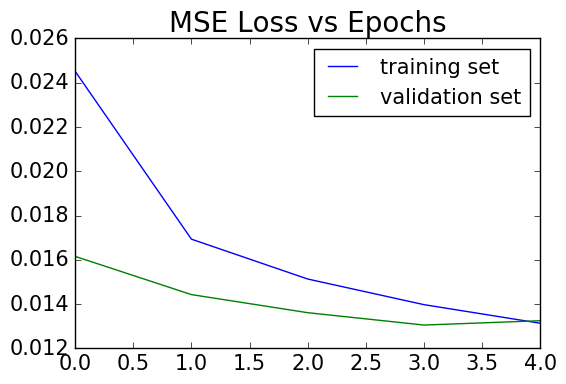

MSE for X_train: 22578 0.0118
MSE for X_valid: 390 0.0131 

Epochs: 5


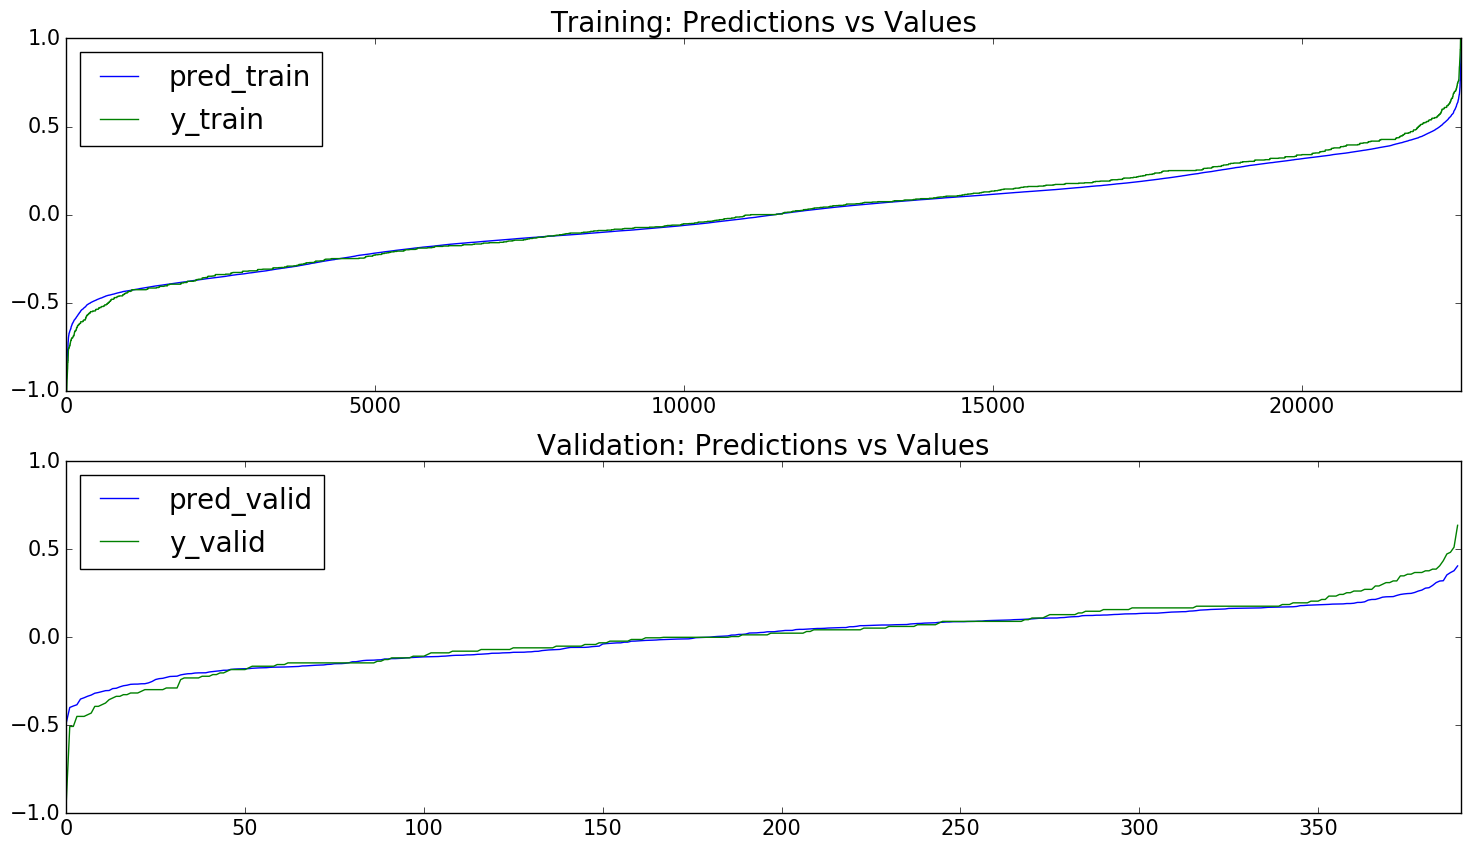

In [11]:
epochs = 5

model = get_model()
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
X_train, X_valid, y_train, y_valid = get_train_valid_data()
history = model.fit(X_train, y_train, validation_split=0.1, shuffle=True, epochs=epochs, verbose=1) 

plot_loss(history)
error_train = plot_errors()
model.save('model_23_6.h5')

# Normalization: X/127.5 - 1.0 --> (-1.0, 1.0)

Training and Validation, Before Preprocessing...

X_train Samples, Steering mean, Steering stdev: 11289 0.0082 0.2781
X_valid Samples, Steering mean, Steering stdev: 390 0.0147 0.1827 

Training and Validation, After Preprocessing...

X_train Samples, Steering mean, Steering stdev: 22578 -0.0 0.2783
X_valid Samples, Steering mean, Steering stdev: 390 0.0147 0.1827 

Train on 20320 samples, validate on 2258 samples
Epoch 1/5
20320/20320 [==============================] - 53s - loss: 0.0279 - val_loss: 0.0190
Epoch 2/5
20320/20320 [==============================] - 52s - loss: 0.0181 - val_loss: 0.0172
Epoch 3/5
20320/20320 [==============================] - 52s - loss: 0.0160 - val_loss: 0.0167
Epoch 4/5
20320/20320 [==============================] - 52s - loss: 0.0149 - val_loss: 0.0152
Epoch 5/5
20320/20320 [==============================] - 52s - loss: 0.0141 - val_loss: 0.0144


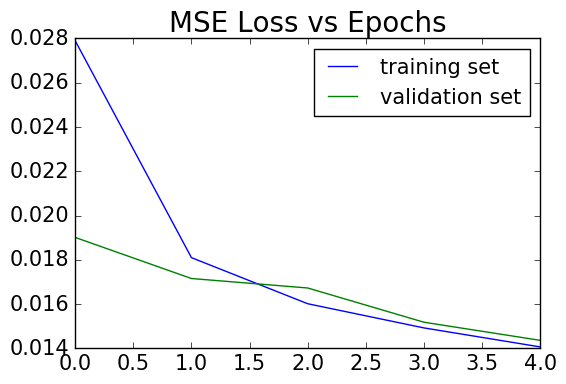

MSE for X_train: 22578 0.0127
MSE for X_valid: 390 0.0148 

Epochs: 5


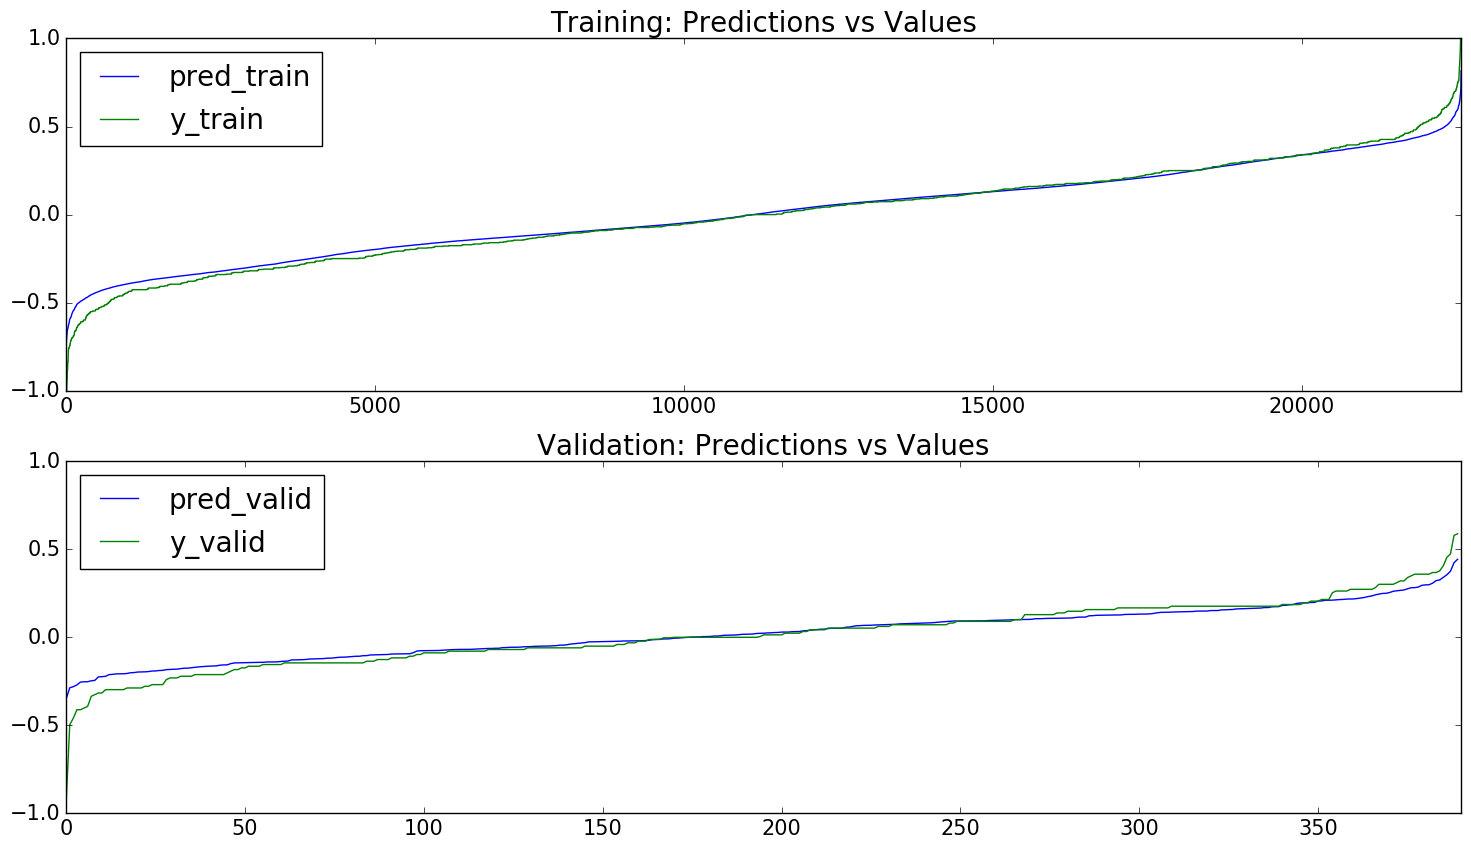

In [13]:
epochs = 5

model = get_model()
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
X_train, X_valid, y_train, y_valid = get_train_valid_data()
history = model.fit(X_train, y_train, validation_split=0.1, shuffle=True, epochs=epochs, verbose=1) 

plot_loss(history)
error_train = plot_errors()
model.save('model_23_7.h5')

# Normalization: X/255.0 --> (0, 1.0)

## Discussion

The biggest challenge was definitely handling the large number of computations. The most effective solution for training models was to use AWS GPU (g2.2xlarge) instances and using my laptop for simulation runs. The NVIDIA GPU on my laptop (GT 730M) needed a vacuum cooling fan to run at reasonable temperatures. This project would be impossible without GPUs!

**Cropping** to remove the top portion of each image was very effective. Since driving focuses attention at the horizon of the road surface, additional cropping at the bottom of the images would probably also give great results. 

**Resizing** the images (96,96) dramatically reduces the amount of data that needs to fit into memory and so data generators were not needed. It would be interesting to explore the lower limits for resizing images since this seems to be a strong factor to performance.  

**Normalizing** to (-1,1) seemed to provide better results during training than (0,1), but both performed well during the actual simulator runs.  

**Dropout** was not needed to prevent overfitting since the model performed so well with current settings.  

The single best improvement that I can think of would be to write the code in C++ (for speed), along with adding the following transformations for real (and more challenging) driving conditions: (1) random shift, (2) random shear, (3) random rotation, (4) random gamma, (5) random brightness, (6) color space (YUV), (7) histogram equalization.

I'm very happy with the results of this project. Making sure that you have plenty of GPU resources and working with established models definitely frees up time for working with the actual data! I also did some exploration with Boosting and Ensembles, but the results were so good those performance boosters will need to wait for another project!